### 1. Dataset Overview
* Total number of videos per class or class distribution
* Total size (in GB) of each class folder
* Average file size
* File extensions/formats

In [ ]:
dataset_path = r"d:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset_Copy"

In [34]:
import os
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

def get_dataset_overview(dataset_path):
    overview_data = []

    for class_dir in tqdm(os.listdir(dataset_path), desc="Scanning classes"):
        class_path = os.path.join(dataset_path, class_dir)
        
        if os.path.isdir(class_path):
            total_size = 0
            file_count = 0
            extensions = defaultdict(int)
            sizes = []

            for file in tqdm(os.listdir(class_path), desc=f"Processing {class_dir}", leave=False):
                file_path = os.path.join(class_path, file)

                if os.path.isfile(file_path):
                    ext = os.path.splitext(file)[1].lower()
                    extensions[ext] += 1
                    
                    try:
                        size = os.path.getsize(file_path)
                        sizes.append(size)
                        total_size += size
                        file_count += 1
                    except Exception as e:
                        print(f"⚠️ Error reading {file_path}: {e}")

            # Convert sizes to readable format
            total_size_gb = round(total_size / (1024 ** 3), 2)
            avg_size_mb = round((sum(sizes) / file_count) / (1024 ** 2), 2) if file_count else 0

            overview_data.append({
                "Class": class_dir,
                "Total Videos": file_count,
                "Total Size (GB)": total_size_gb,
                "Average File Size (MB)": avg_size_mb,
                "File Formats": dict(extensions)
            })

    return pd.DataFrame(overview_data)
 
df_overview = get_dataset_overview(dataset_path)

# Display
pd.set_option("display.max_colwidth", None)
print("\n📊 Dataset Overview:\n")
print(df_overview.to_string(index=False))

Scanning classes: 100%|██████████| 2/2 [00:00<00:00, 28.88it/s]


📊 Dataset Overview:

  Class  Total Videos  Total Size (GB)  Average File Size (MB)  File Formats
    ASD           150             0.68                    4.66 {'.mp4': 150}
NON-ASD           150             0.90                    6.13 {'.mp4': 150}


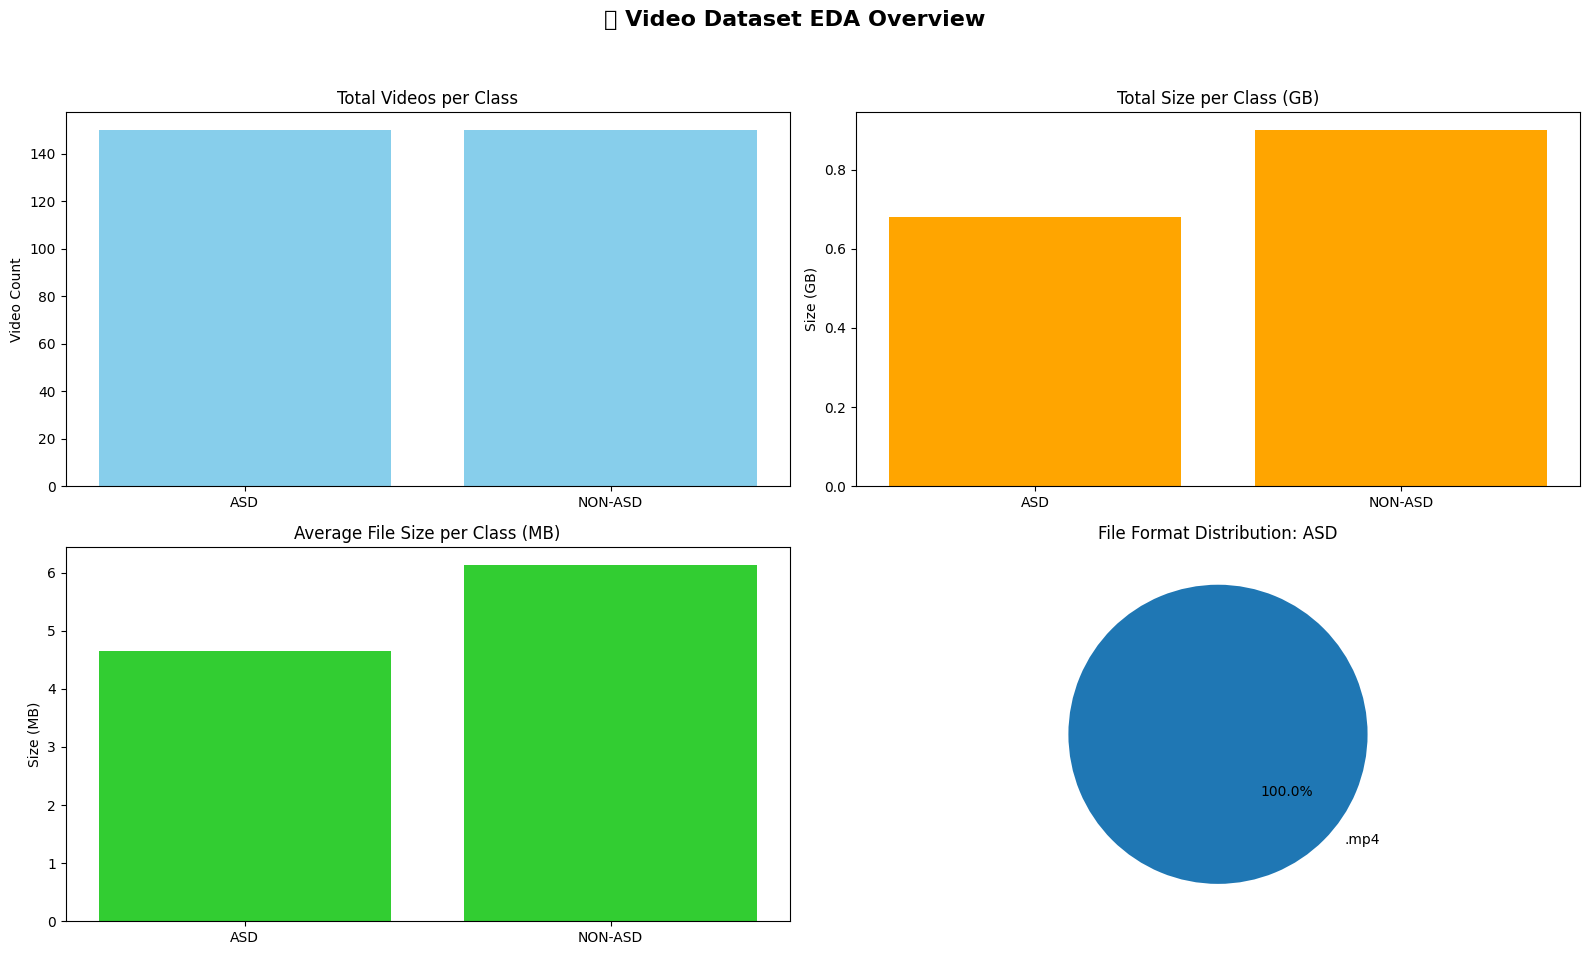

In [14]:
import matplotlib.pyplot as plt

def plot_dataset_eda(df):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle("🎥 Video Dataset EDA Overview", fontsize=16, fontweight='bold')

    # 1. Total Videos per Class
    axs[0, 0].bar(df['Class'], df['Total Videos'], color='skyblue')
    axs[0, 0].set_title('Total Videos per Class')
    axs[0, 0].set_ylabel('Video Count')

    # 2. Total Size in GB per Class
    axs[0, 1].bar(df['Class'], df['Total Size (GB)'], color='orange')
    axs[0, 1].set_title('Total Size per Class (GB)')
    axs[0, 1].set_ylabel('Size (GB)')

    # 3. Average File Size
    axs[1, 0].bar(df['Class'], df['Average File Size (MB)'], color='limegreen')
    axs[1, 0].set_title('Average File Size per Class (MB)')
    axs[1, 0].set_ylabel('Size (MB)')

    # 4. File Format Distribution (pie charts for each class)
    for idx, row in df.iterrows():
        formats = row['File Formats']
        labels = list(formats.keys())
        sizes = list(formats.values())
        axs[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
        axs[1, 1].set_title(f"File Format Distribution: {row['Class']}")
        break  # only one pie chart due to subplot space

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_dataset_eda(df_overview)

# 2. Basic Video Statistics or Metadeta 
For each video:
* Class	
* File Name	
* Path	
* File Format
* Duration(s)	
* Frame Count	
* FPS	
* Resolution	
* Aspect Ratio
* Video quality	
* video size
* Gender
* behavior type
* start and end times of the behavior
* Corrupted

In [5]:
# Define the Helper Functions
import os
import re
import cv2
from deepface import DeepFace

def detect_gender(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    if ret:
        try:
            result = DeepFace.analyze(frame, actions=["gender"], enforce_detection=False)
            return result[0]['dominant_gender'].capitalize()
        except Exception as e:
            print(f"⚠️ Gender detection failed on {video_path}: {e}")
            return "Unknown"
    return "Unknown"

 


In [6]:
from pathlib import Path

def extract_video_stats(video_path, class_name, filename):
    stats = {
        "Class": class_name,
        "File Name": filename,
        "Path": video_path,
        "File Format": Path(video_path).suffix.lower(),
        "Video Size (MB)": None,
        "Video Quality": None,
        "Duration (s)": None,
        "Frame Count": None,
        "FPS": None,
        "Resolution": None,
        "Aspect Ratio": None,
        "Gender": "Unknown",
        "Corrupted": False
    }

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            stats["Corrupted"] = True
            return stats

        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        duration = frame_count / fps if fps > 0 else 0

        quality = "HD" if width >= 1280 else "SD" if width >= 640 else "Low"

        stats.update({
            "Duration (s)": round(duration, 2),
            "Frame Count": frame_count,
            "FPS": round(fps, 2),
            "Resolution": f"{width}x{height}",
            "Aspect Ratio": round(width / height, 2) if height else None,
            "Video Quality": quality,
            "Video Size (MB)": round(os.path.getsize(video_path) / (1024 ** 2), 2)
        })

        # Enriched fields
        gender = detect_gender(video_path)
        stats.update({
            "Gender": gender
        })

        cap.release()

    except Exception as e:
        print(f"❌ Error reading {video_path}: {e}")
        stats["Corrupted"] = True

    return stats


In [7]:
# Usage in Your Loop
import pandas as pd
from tqdm import tqdm

def scan_videos(dataset_path):
    video_data = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path): continue

        for filename in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            if filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
                file_path = os.path.join(class_path, filename)
                stats = extract_video_stats(file_path, class_name, filename)
                video_data.append(stats)

    return pd.DataFrame(video_data)

video_stats_df = scan_videos(dataset_path)
video_stats_df.to_csv("enhanced_video_metadata.csv", index=False)
print("✅ Metadata saved to enhanced_video_metadata.csv")


Processing NON-ASD: 100%|██████████| 150/150 [08:28<00:00,  3.39s/it]

✅ Metadata saved to enhanced_video_metadata.csv


C:\Users\SHINU RATHOD\AppData\Local\Temp\ipykernel_6240\767350616.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=aspect_bins, ax=axs[1, 0], palette="Set2")
C:\Users\SHINU RATHOD\AppData\Local\Temp\ipykernel_6240\767350616.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=video_stats_df["Corrupted"], ax=axs[1, 1], palette="Set1")


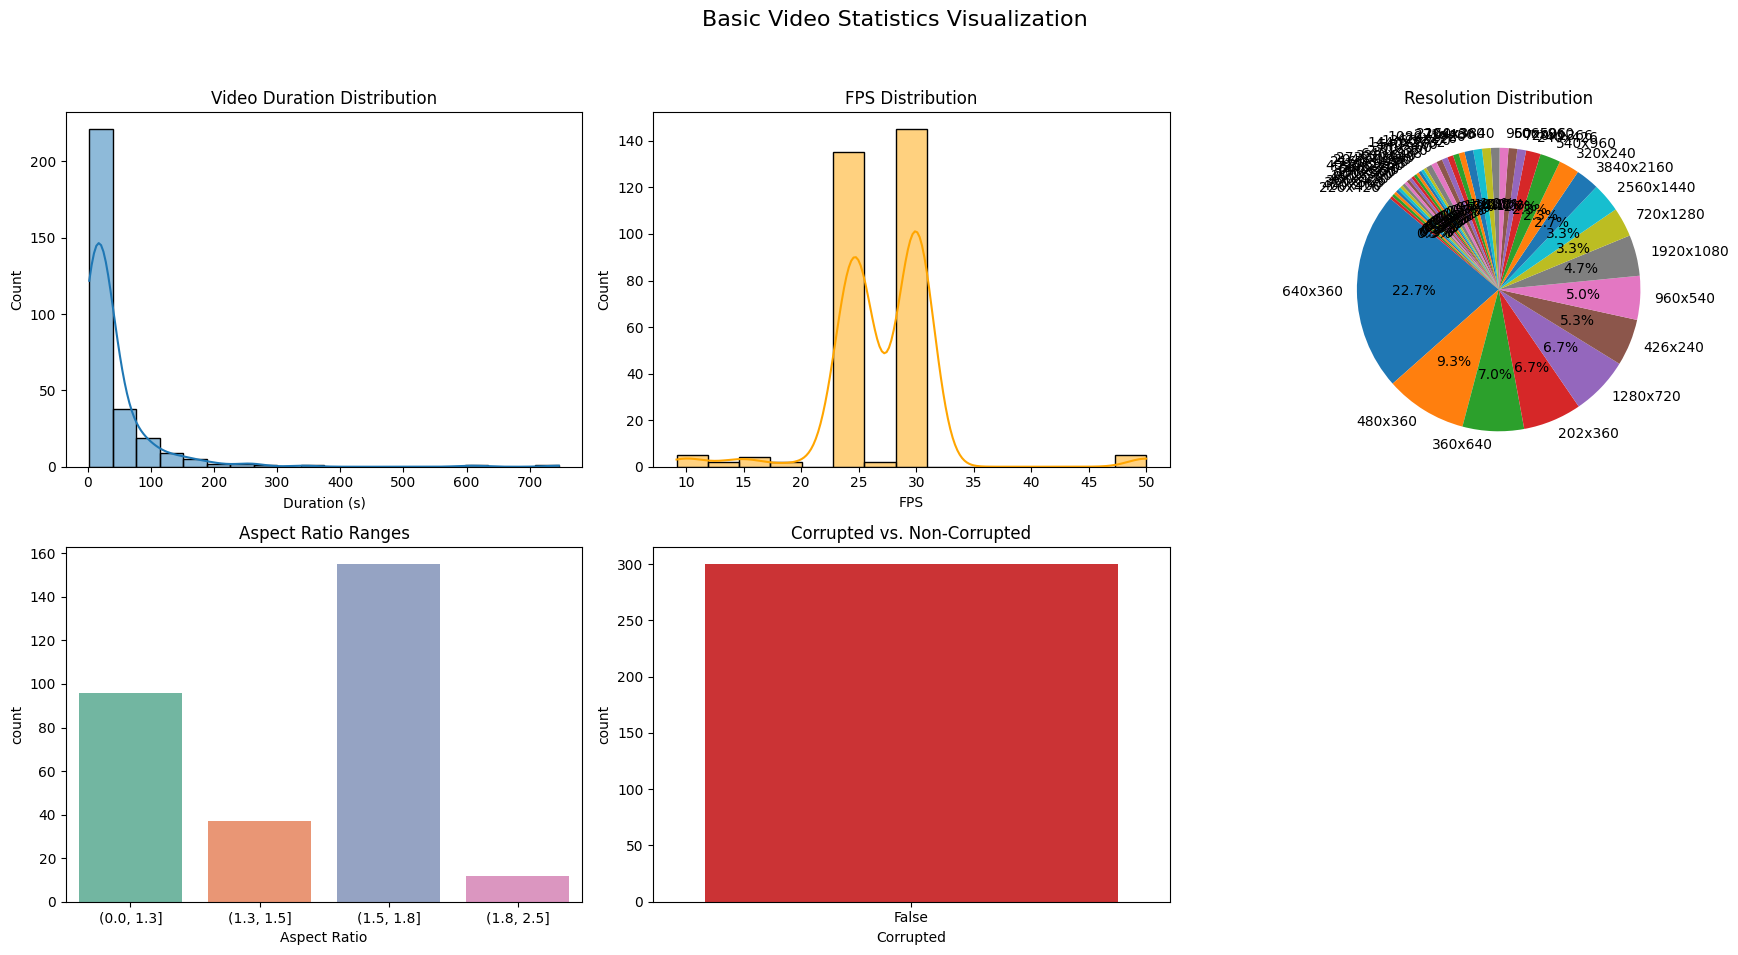

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean and prep data
clean_df = video_stats_df[~video_stats_df["Corrupted"]]

# Setup subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Basic Video Statistics Visualization", fontsize=16)

# Duration histogram
sns.histplot(clean_df["Duration (s)"], bins=20, ax=axs[0, 0], kde=True)
axs[0, 0].set_title("Video Duration Distribution")

# FPS histogram
sns.histplot(clean_df["FPS"], bins=15, ax=axs[0, 1], color="orange", kde=True)
axs[0, 1].set_title("FPS Distribution")

# Resolution pie chart
res_counts = clean_df["Resolution"].value_counts()
axs[0, 2].pie(res_counts, labels=res_counts.index, autopct='%1.1f%%', startangle=140)
axs[0, 2].set_title("Resolution Distribution")

# Aspect ratio bar
aspect_bins = pd.cut(clean_df["Aspect Ratio"], bins=[0, 1.3, 1.5, 1.8, 2.5])
sns.countplot(x=aspect_bins, ax=axs[1, 0], palette="Set2")
axs[1, 0].set_title("Aspect Ratio Ranges")

# Corrupted files bar
sns.countplot(x=video_stats_df["Corrupted"], ax=axs[1, 1], palette="Set1")
axs[1, 1].set_title("Corrupted vs. Non-Corrupted")

# Remove empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [11]:
# Identify potential outliers
duration_outliers = clean_df[clean_df["Duration (s)"] > clean_df["Duration (s)"].quantile(0.95)]
fps_outliers = clean_df[clean_df["FPS"] > clean_df["FPS"].quantile(0.95)]
corrupted_files = video_stats_df[video_stats_df["Corrupted"]]

print("🧯 Duration Outliers:")
print(duration_outliers[["File Name", "Duration (s)", "Class"]].head())

print("\n⚡ FPS Outliers:")
print(fps_outliers[["File Name", "FPS", "Class"]].head())

print("\n❌ Corrupted Files:")
print(corrupted_files[["File Name", "Class"]].head())

🧯 Duration Outliers:
                      File Name  Duration (s) Class
3               0g51c2BCqu8.mp4        167.33   ASD
9   2364531100353534 - Trim.mp4        608.29   ASD
12   327182825893700 - Trim.mp4        262.90   ASD
17              5Ps9iE8mPqY.mp4        253.74   ASD
24      6wmrM_JCDVc - Trim1.mp4        193.96   ASD

⚡ FPS Outliers:
                      File Name    FPS Class
29   831091434545664 - Trim.mp4  30.06   ASD
79       g-bnBByq9Zc - Trim.mp4  30.04   ASD
82       GCcJWyoGoMY - Trim.mp4  30.04   ASD
93       HWoLOw8Xzv4 - Trim.mp4  30.05   ASD
117      lvQPoNRpQcw - Trim.mp4  30.02   ASD

❌ Corrupted Files:
Empty DataFrame
Columns: [File Name, Class]
Index: []


### 3. Summary Statistics
* Distribution of video duration across both classes
* Distribution of resolutions
* Class imbalance (if any)

In [16]:
video_stats_df.head()

Class               File Name  \
0   ASD  -hSduu8zDzI - Trim.mp4   
1   ASD         -IVN2XJ4YT8.mp4   
2   ASD         0EZ8D5VS1wE.mp4   
3   ASD         0g51c2BCqu8.mp4   
4   ASD                   1.mp4   

                                                                                                                                                               Path  \
0  D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\-hSduu8zDzI - Trim.mp4   
1         D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\-IVN2XJ4YT8.mp4   
2         D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\0EZ8D5VS1wE.mp4   
3         D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\0g51c2BCqu8.mp4   
4                   D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\1.mp4   

   Duration (s)  Frame Count    FPS Resolution  Aspect Ratio  Corrupted  
0         11.48          344  29.97    640x360          1.78      False  
1         14.70          441  30.00    640x360          1.78      False  
2         30.46          911  29.91    640x360          1.78      False  
3        167.33         5015  29.97    640x360          1.78      False  
4         28.32          680  24.01    640x360          1.78      False

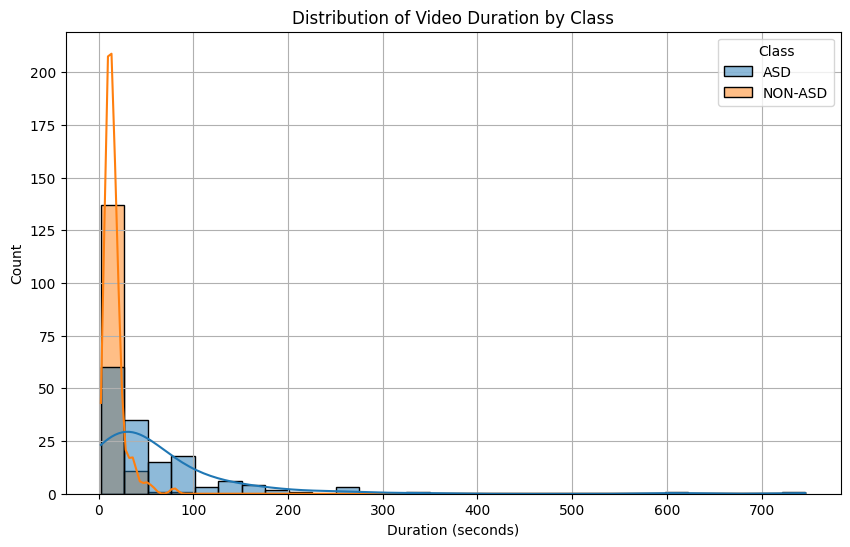

In [13]:
# * Distribution of video duration across both classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=video_stats_df[~video_stats_df["Corrupted"]], 
             x="Duration (s)", 
             hue="Class", 
             bins=30, 
             kde=True)
plt.title("Distribution of Video Duration by Class")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

here duration would be anything but lower the duration with video include autistic and non-autistic char would be better for model building for faster convergence

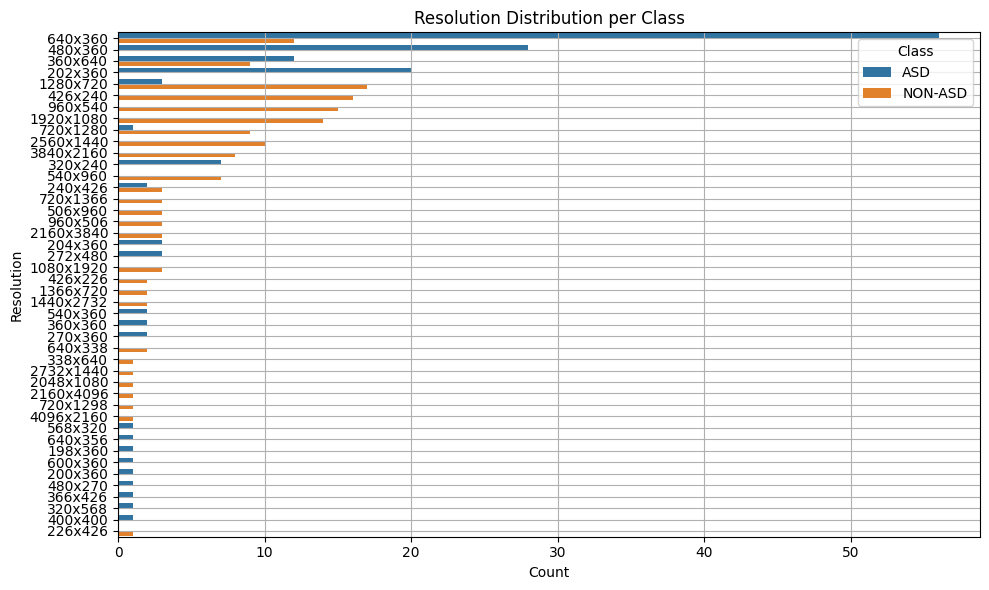

In [14]:
# * Distribution of resolutions
plt.figure(figsize=(10, 6))
sns.countplot(data=video_stats_df[~video_stats_df["Corrupted"]], 
              y="Resolution", 
              hue="Class", 
              order=video_stats_df["Resolution"].value_counts().index)
plt.title("Resolution Distribution per Class")
plt.xlabel("Count")
plt.ylabel("Resolution")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\SHINU RATHOD\AppData\Local\Temp\ipykernel_6240\2346321568.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=video_stats_df, x="Class", palette="viridis")


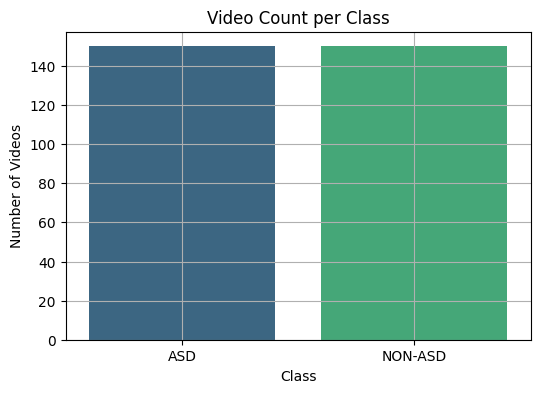

📊 Class Distribution:
 Class
ASD        150
NON-ASD    150
Name: count, dtype: int64


In [15]:
# * Class imbalance (if any)
plt.figure(figsize=(6, 4))
sns.countplot(data=video_stats_df, x="Class", palette="viridis")
plt.title("Video Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Videos")
plt.grid(True)
plt.show()

# Also show numeric counts
class_counts = video_stats_df["Class"].value_counts()
print("📊 Class Distribution:\n", class_counts)


In [16]:
summary_df = video_stats_df.groupby("Class").agg({
    "Duration (s)": ["mean", "std", "min", "max"],
    "FPS": ["mean", "std"],
    "Resolution": pd.Series.nunique,
    "Corrupted": "sum"
}).reset_index()

print("\n🧾 Summary Statistics Table:")
print(summary_df)


🧾 Summary Statistics Table:
     Class Duration (s)                                 FPS            \
                   mean        std   min     max       mean       std   
0      ASD    64.354133  92.455394  2.49  746.25  27.366467  4.916750   
1  NON-ASD    15.888000  10.195938  3.84   79.61  26.990933  4.878349   

  Resolution Corrupted  
     nunique       sum  
0         22         0  
1         27         0  


### 4. Optional Deep Checks (Advanced EDA)
* Sample frame visualization
* Sample audio check (if any)
* Frame brightness/contrast distributions
* Average color histogram per video

In [17]:
video_stats_df.head()

Class               File Name  \
0   ASD  -hSduu8zDzI - Trim.mp4   
1   ASD         -IVN2XJ4YT8.mp4   
2   ASD         0EZ8D5VS1wE.mp4   
3   ASD         0g51c2BCqu8.mp4   
4   ASD                   1.mp4   

                                                                                                                                                               Path  \
0  D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\-hSduu8zDzI - Trim.mp4   
1         D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\-IVN2XJ4YT8.mp4   
2         D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\0EZ8D5VS1wE.mp4   
3         D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\0g51c2BCqu8.mp4   
4                   D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\1.mp4   

   Duration (s)  Frame Count    FPS Resolution  Aspect Ratio  Corrupted  
0         11.48          344  29.97    640x360          1.78      False  
1         14.70          441  30.00    640x360          1.78      False  
2         30.46          911  29.91    640x360          1.78      False  
3        167.33         5015  29.97    640x360          1.78      False  
4         28.32          680  24.01    640x360          1.78      False

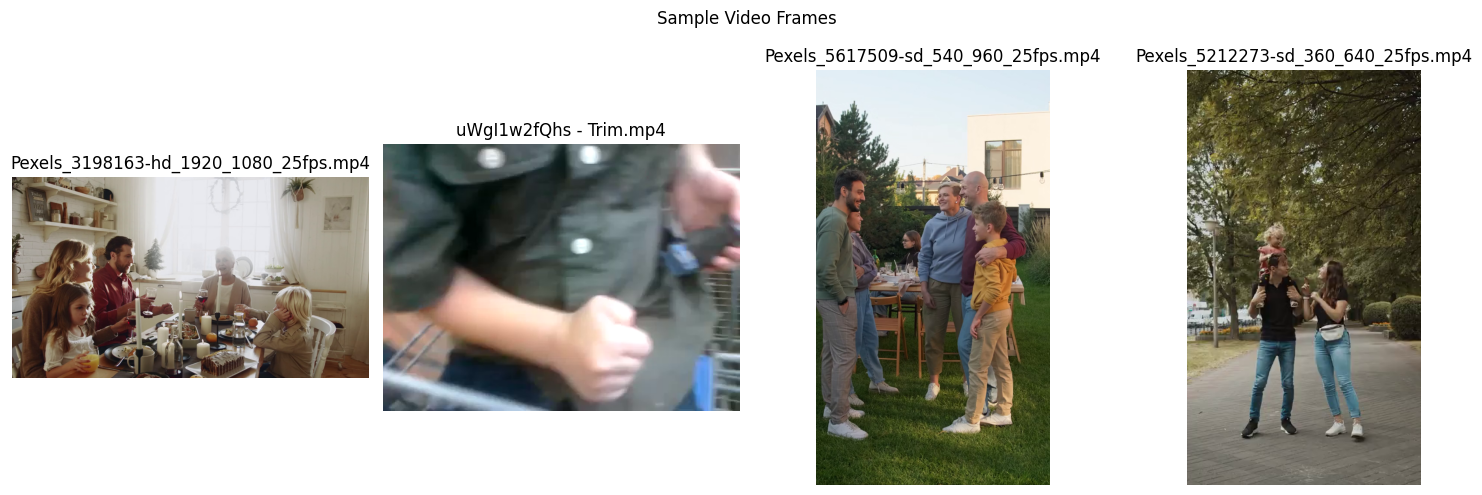

In [18]:
# * Sample frame visualization
import cv2
import matplotlib.pyplot as plt
import os
import random

def show_sample_frames(video_paths, num_samples=4):
    sample_paths = random.sample(video_paths, min(len(video_paths), num_samples))
    plt.figure(figsize=(15, 5))
    
    for idx, path in enumerate(sample_paths):
        cap = cv2.VideoCapture(path)
        success, frame = cap.read()
        cap.release()
        if success:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_samples, idx + 1)
            plt.imshow(frame_rgb)
            plt.title(os.path.basename(path))
            plt.axis('off')
        else:
            print(f"❌ Couldn't read: {path}")
    
    plt.suptitle("Sample Video Frames")
    plt.tight_layout()
    plt.show()

# Usage
video_paths = video_stats_df[~video_stats_df['Corrupted']]['Path'].tolist()
show_sample_frames(video_paths)


In [5]:
# * Sample audio check (if any)
from moviepy.editor import VideoFileClip
import IPython.display as ipd

def play_sample_audio(video_path):
    try:
        clip = VideoFileClip(video_path)
        audio = clip.audio
        if audio:
            audio.write_audiofile("temp_audio.wav")
            return ipd.Audio("temp_audio.wav")
        else:
            print("No audio found.")
    except Exception as e:
        print("Error:", e)

# Try one sample
video_paths = r"D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset\ASD\_M8YkVVb5dg.mp4"
play_sample_audio(video_paths)

MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


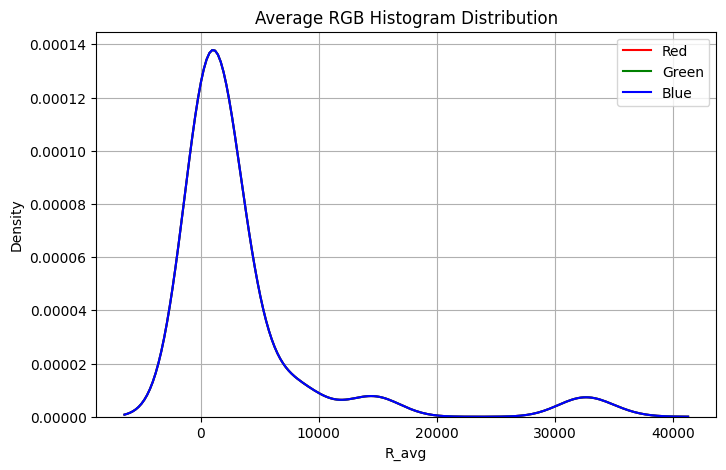

In [20]:
import seaborn as sns
# * Frame brightness/contrast distributions
def get_avg_color_histogram(video_path):
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    cap.release()
    if success:
        chans = cv2.split(frame)
        features = [cv2.calcHist([chan], [0], None, [256], [0, 256]).flatten().mean() for chan in chans]
        return features
    return [0, 0, 0]

video_stats_df[['R_avg', 'G_avg', 'B_avg']] = video_stats_df['Path'].apply(
    lambda x: pd.Series(get_avg_color_histogram(x)))

# Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(video_stats_df['R_avg'], label='Red', color='r')
sns.kdeplot(video_stats_df['G_avg'], label='Green', color='g')
sns.kdeplot(video_stats_df['B_avg'], label='Blue', color='b')
plt.title("Average RGB Histogram Distribution")
plt.legend()
plt.grid(True)
plt.show()


### Pose Estimation
* Iterate over videos in ASD-Dataset/ASD and ASD-Dataset/NON-ASD
* Extract a fixed number of frames per video (e.g. 10)
* Apply MediaPipe Pose Estimation
* Save extracted pose keypoints (x, y, visibility for 33 landmarks)
* Save results in a CSV format for downstream modeling

# MediaPipe

In [12]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
from tqdm import tqdm

# Setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.7)

# Parameters
NUM_FRAMES = 20
DATASET_DIR = r"D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset"
OUTPUT_CSV = "pose_keypoints.csv"

# Output list
all_keypoints = []

def extract_pose_from_frame(frame):
    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.pose_landmarks:
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.visibility])
        return keypoints
    else:
        return [None] * (33 * 3)

def extract_uniform_frames(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = cap.read()
        if success:
            frames.append(frame)
    cap.release()
    return frames

def process_video(video_path, label, video_name):
    frames = extract_uniform_frames(video_path, NUM_FRAMES)
    for i, frame in enumerate(frames):
        keypoints = extract_pose_from_frame(frame)
        all_keypoints.append([video_name, label, i] + keypoints)

def run_pose_extraction():
    for label in os.listdir(DATASET_DIR):
        class_dir = os.path.join(DATASET_DIR, label)
        if not os.path.isdir(class_dir): continue

        for file in tqdm(os.listdir(class_dir), desc=f"Processing {label}"):
            if file.lower().endswith(('.mp4', '.avi', '.mov')):
                video_path = os.path.join(class_dir, file)
                video_name = os.path.splitext(file)[0]
                try:
                    process_video(video_path, label, video_name)
                except Exception as e:
                    print(f"❌ Failed: {video_path} | {e}")

    # Convert to DataFrame
    column_names = ['video_name', 'label', 'frame']
    for i in range(33):
        column_names += [f'x{i}', f'y{i}', f'vis{i}']

    df = pd.DataFrame(all_keypoints, columns=column_names)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved keypoints to {OUTPUT_CSV}")

# Run
if __name__ == "__main__":
    run_pose_extraction()


Processing NON-ASD: 100%|██████████| 150/150 [20:08<00:00,  8.05s/it]


Saved keypoints to pose_keypoints.csv


In [15]:
# Step-by-Step: Visualize Pose Landmarks from CSV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Load keypoints CSV
df = pd.read_csv("pose_keypoints1.csv")

# MediaPipe Pose connections (33 landmarks)
# Reference: https://github.com/google/mediapipe/blob/master/mediapipe/modules/pose_landmark/pose_landmarks_index.json
POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7),      # right arm
    (0, 4), (4, 5), (5, 6), (6, 8),      # left arm
    (9, 10),                             # shoulders
    (11, 12), (11, 13), (13, 15),        # left leg
    (12, 14), (14, 16),                  # right leg
    (11, 23), (12, 24),                  # hip to legs
    (23, 24), (23, 25), (25, 27),        # left lower leg
    (24, 26), (26, 28),                  # right lower leg
    (27, 29), (28, 30),                  # feet
    (15, 17), (16, 18),                  # hands
]

def plot_pose(row, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 7))

    xs = [row[f'x{i}'] for i in range(33)]
    ys = [row[f'y{i}'] for i in range(33)]
    vis = [row[f'vis{i}'] for i in range(33)]

    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)  # Invert y-axis (like image coordinates)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"{row['video_name']} | Frame {row['frame']} | {row['label']}")

    # Plot connections
    for p1, p2 in POSE_CONNECTIONS:
        if vis[p1] > 0.5 and vis[p2] > 0.5:
            ax.plot([xs[p1], xs[p2]], [ys[p1], ys[p2]], 'k-', linewidth=2)

    # Plot landmarks
    for i in range(33):
        if vis[i] > 0.5:
            ax.scatter(xs[i], ys[i], s=20, color='blue')

def show_random_poses(df, num=4):
    sample = df.dropna().sample(num)
    fig, axes = plt.subplots(1, num, figsize=(5 * num, 6))
    for i, (_, row) in enumerate(sample.iterrows()):
        plot_pose(row, ax=axes[i])
    plt.tight_layout()
    plt.show()

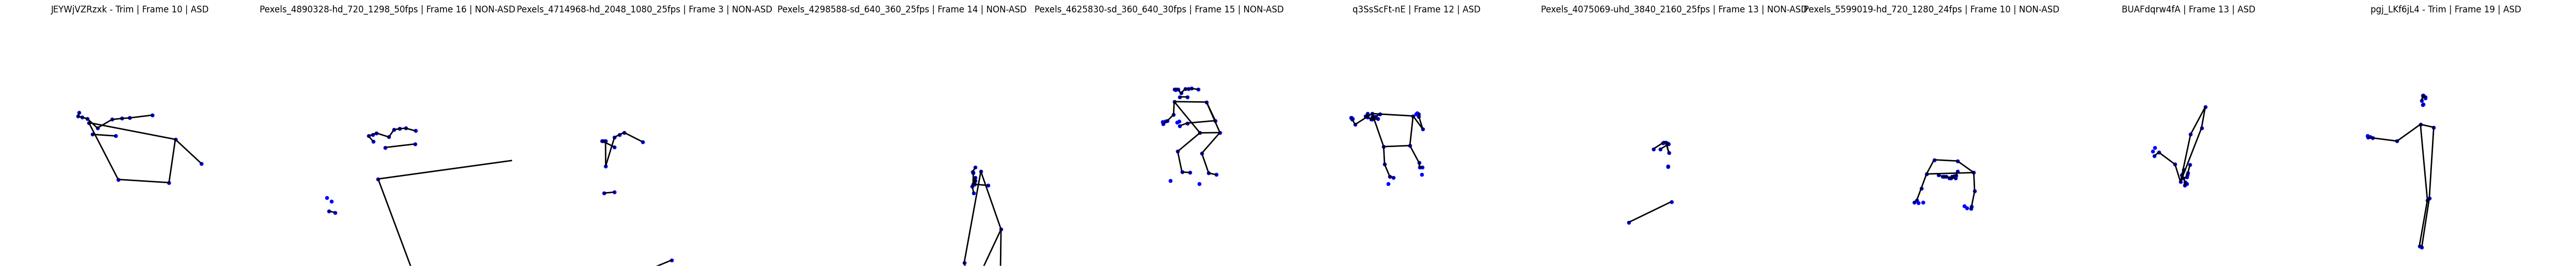

In [16]:
show_random_poses(df, num=10)

## Visualize landmarks for random frames?

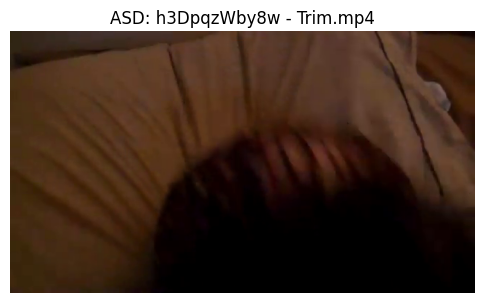

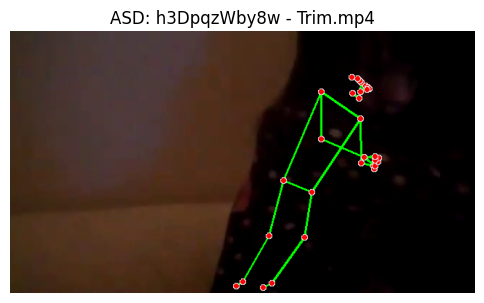

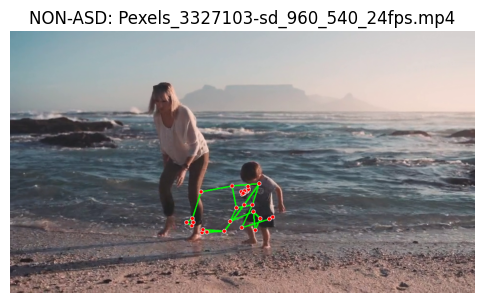

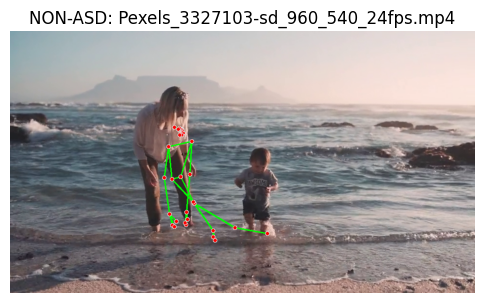

In [20]:
# Setup
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

DATASET_DIR = r"D:\Class\06_DL\02_CNN\03_Computer Vision\1_Object_Detection\Projects\Autistic Spectrum Disorders\05_Research Tracker\Datasets\Dataset"
SAMPLES_PER_CLASS = 1
FRAMES_PER_VIDEO = 2

def get_random_video_paths(class_dir, num_samples=2):
    video_files = [f for f in os.listdir(class_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
    sampled = random.sample(video_files, min(num_samples, len(video_files)))
    return [os.path.join(class_dir, v) for v in sampled]

def extract_and_plot_frames(video_path, label, frame_count=1):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = random.sample(range(total_frames), min(frame_count, total_frames))
    
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = cap.read()
        if success:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame_rgb)

            if results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    frame_rgb, 
                    results.pose_landmarks, 
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(255,0,0), thickness=2),
                    mp_drawing.DrawingSpec(color=(0,255,0), thickness=2)
                )

            plt.figure(figsize=(6, 6))
            plt.imshow(frame_rgb)
            plt.axis("off")
            plt.title(f"{label}: {os.path.basename(video_path)}")
            plt.show()

    cap.release()

def visualize_samples():
    for label in ["ASD", "NON-ASD"]:
        class_dir = os.path.join(DATASET_DIR, label)
        sample_paths = get_random_video_paths(class_dir, SAMPLES_PER_CLASS)
        for video_path in sample_paths:
            extract_and_plot_frames(video_path, label, frame_count=FRAMES_PER_VIDEO)

# Run it
visualize_samples()


### Feature Preparation — From Landmarks to ML

In [18]:
# Store stat features per video
stat_features = []
labels = []

for video_name, group in df.groupby("video_name"):
    group_sorted = group.sort_values("frame")
    pose_data = group_sorted[[col for col in df.columns if col.startswith(('x', 'y', 'vis'))]]

    stats = []
    for col in pose_data.columns:
        stats.extend([
            pose_data[col].mean(),
            pose_data[col].std(),
            pose_data[col].min(),
            pose_data[col].max(),
        ])
    stat_features.append(stats)
    labels.append(group_sorted["label"].iloc[0])

X_stats = np.array(stat_features, dtype=np.float32)
y_labels = np.array(labels)

print("✅ Statistical features shape:", X_stats.shape)

✅ Statistical features shape: (300, 396)


# 2. OpenPose

In [ ]:
# Webcam Test (CPU version)
bin\OpenPoseDemo.exe --hand --face

# Example with more control:
# bin\OpenPoseDemo.exe --hand --face --display 2 --net_resolution "320x176"  # if net_resolution is low then its not working properly

In [ ]:
# OpenPose on a Video File
bin\OpenPoseDemo.exe --video examples\media\asd1.mp4 --hand --face --write_video output\asd1_output.avi --write_json output\json\asd1\ --display 1 --net_resolution "320x176"


%cd /content/drive/MyDrive/OpenPose/openpose-1.7.0-binaries-win64-cpu-python3.7-flir-3d/openpose/bin
!pwd

# Now run OpenPose command
!./OpenPoseDemo.exe --video "/content/2uf_A92mqtA.mp4" --hand --face --write_video output/video_output.avi --write_json output/json/ --net_resolution "640x352" --scale_number 4 --scale_gap 0.25 --num_gpu 1 --model_pose BODY_25


# AlphaPose

In [ ]:
!pip install numpy cython torch torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
git clone https://github.com/MVIG-SJTU/AlphaPose.git
cd AlphaPose